# Basic Example of the CASCADe-filtering package #

This notebook shows the basic functions of the CASCADe-filtering module. This filtering package is developed to identify 'bad' pixels in a spectral image cube, especially those obtained with transit observations. The package can identify bad pixels and create a cleaned version of the data together with a fitered (smoothed) version of the data cube. The filtering was designed such, that it is edge preserving, meaning that the filtered data has the same spatial spectral profile as the input data. This means it can be used to create an extraction weight for optimal spectral extraction.

The filtering applied in this package is similar to that implemented by Nagano & Matsuyama and Kuwahara. Using a stack of anisotropic filter kernels, for each data pixel an optimal filter kernel is selected such that the optimal filter has the lowest variance. 

To run this example we first we import the relevant modules.

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from cascade_filtering.filtering import DirectionalFilter
from cascade_filtering.kernel import FilterKernel

%matplotlib inline

Next we create a simple test data set, consisting of a data cube of 50 (spectral) images, which contain a spectrum like intensity profile.

In [26]:
#test data set
TEST_IMAGE_CUBE = np.ones((50, 128, 128), dtype=np.float64)
TEST_IMAGE_CUBE[:, 30:90, 80:83] = 4.0
TEST_IMAGE_MASK = np.zeros_like(TEST_IMAGE_CUBE, dtype=bool)
TEST_IMAGE_MASK_BLANK = np.zeros_like(TEST_IMAGE_CUBE, dtype=bool)

We then add some random cosmic noise to the test data set and create a data cube indicating the uncertainty (gaussian error) on the data.

In [27]:
# random cosmics
N = 80
random_indicesy = np.arange(0, TEST_IMAGE_CUBE.shape[1])    # array of all indices
random_indicesx = np.arange(0, TEST_IMAGE_CUBE.shape[2])  
np.random.seed(666) 
np.random.shuffle(random_indicesx)                          # shuffle the array
np.random.shuffle(random_indicesy) 
TEST_IMAGE_CUBE[:, random_indicesy[:N], random_indicesx[:N]] = 10.0
TEST_IMAGE_UNCERTAINTY = TEST_IMAGE_CUBE*0.01
TEST_IMAGE_MASK[:, random_indicesy[:N], random_indicesx[:N]] = True

print(f"Total number of 'bad' pixels: {np.sum(TEST_IMAGE_MASK)}")

Total number of 'bad' pixels: 4000


Finally we define a 'region of interest' which is used to select the region in the spectral images which contains the data of the source we are interested in. Selecting only the relevant part o the data can substantially speed up the processing.  

In [28]:
#region of interest. Defined similar as numpy mask: if True do not use
ROI = np.ones((128, 128), dtype=bool)
ROI[20:100, 62:98] = False

## First Example ##

We now can apply the CASCADe-filtering package on the test data set. We first load an appropriate set of filter kernels, in this case those difined by Kuwahara. We load the relevant kernel and parameters defining it by reading in a configuration file, of which several examples are provided with this distribution. 

In [29]:
    FK = FilterKernel(configuration_file='kuwahara_kernel.conf')
    KERNEL_STACK = FK.kernel_stack

We can now print some basic information about the kernels and plot a few of them.

Kernel configuration parameters: {'kernel_name': 'kuwahara', 'kernel_shape': (7, 7)}
Kernel stack shape: (15, 7, 7)


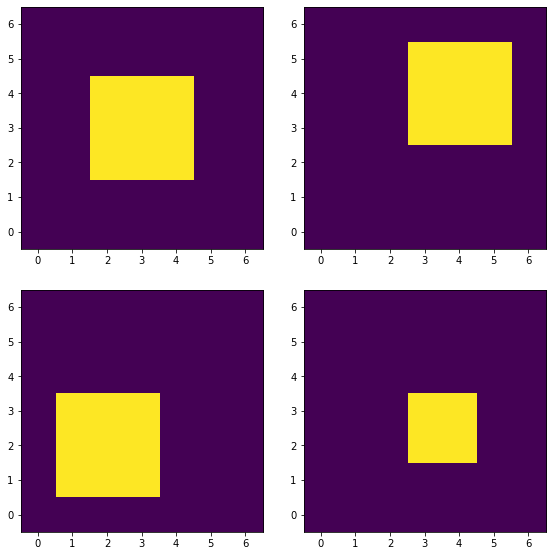

In [30]:
print(f"Kernel configuration parameters: {FK.configuration}")
print(f"Kernel stack shape: {KERNEL_STACK.shape}")

fig, ax = plt.subplots(2,2, figsize=(8,8))
fig.tight_layout(pad=1.0)
ax[0, 0].imshow(KERNEL_STACK[2,...], interpolation=None, origin='lower')
ax[0, 1].imshow(KERNEL_STACK[7,...], interpolation=None, origin='lower')
ax[1, 0].imshow(KERNEL_STACK[9,...], interpolation=None, origin='lower')
ax[1, 1].imshow(KERNEL_STACK[14,...], interpolation=None, origin='lower')
plt.show()

Now we have defined the felter kernels, we can create our directional filter object, load the kernel steck and run the filter on the data. The input parameters to the DirectionalFilter object are the gaussian sigma above which pixels are flagged as bad, the maximum number of iterations over which the filtering is applied and a treshold below which the filtering is deemed to be converged. As a first demonstation we run the filter on the test data using as input mask the bad pixel mask of the test data, which has the bad pixels already identitied. We also use the entire test data set without making use of a region of interest mask.

In [31]:
DF = DirectionalFilter(sigma=4.0, max_iterations=10, acceptance_treshold=0.01)
DF.load_filter_kernels(KERNEL_STACK)
DF.run_filter(TEST_IMAGE_CUBE, TEST_IMAGE_MASK,
              TEST_IMAGE_UNCERTAINTY)

iteration: 1, number of flagged pixel: 4000


We can print some basic information. As one can see we are recovering the total number of bad input pixels.

In [32]:
print(f"Used sigma: {DF.sigma}")
print(f"Maximum number of iterations: {DF.max_iterations}")
print(f"Acceptance treshold: {DF.acceptance_treshold}")
print(f"Acceptance limit (# of pixels): {DF.acceptance_limit}")
print(f"Number of flaged pixels after filtering: {DF.number_of_flagged_pixels}")

Used sigma: 4.0
Maximum number of iterations: 10
Acceptance treshold: 0.01
Acceptance limit (# of pixels): 4000
Number of flaged pixels after filtering: 4000


We can now extract the relevant data and plot the input data and cleaned data as a comparison.

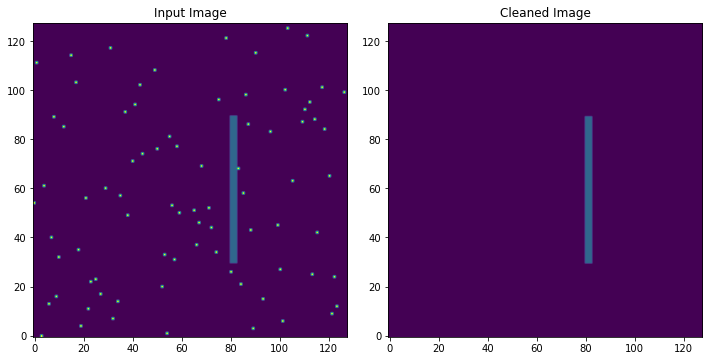

In [33]:
cleaned_image_cube = DF.pp_image_cube
cleaned_image_cube_uncertainty = DF.pp_image_cube_error
filtered_image_cube = DF.optimal_filtered_image_cube
new_bad_pixel_mask = ~DF.cumulative_image_cube_mask.astype(bool)
optimal_filter_kernel_number = DF.index_optimal_filter_kernel[0]
valid_region_fltrd_data = DF.pp_data_cube_valid_index
valid_region_data = DF.pp_roi_image_cube_index

fig, ax = plt.subplots(1,2, figsize=(10,5))
fig.tight_layout(pad=1.0)
ax[0].imshow(TEST_IMAGE_CUBE[valid_region_data][0,...], interpolation=None, origin='lower', vmin=1, vmax=10)
ax[0].set_title('Input Image')
ax[1].imshow(cleaned_image_cube[valid_region_fltrd_data][0, ...], interpolation=None, origin='lower',
             vmin=1, vmax=10)
ax[1].set_title('Cleaned Image')
plt.show()

And also plot the input and output bad pixel masks (should be the same in this case), the selected optimal filter and the filtered (smoothed) data.

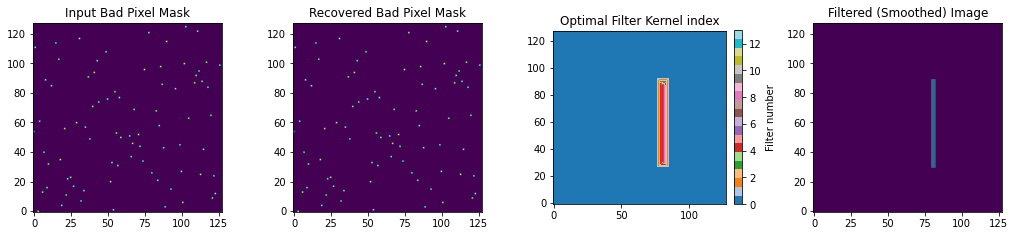

In [34]:
fig, ax = plt.subplots(1,4, figsize=(15,5))
fig.tight_layout(pad=4.0)
ax[0].imshow(TEST_IMAGE_MASK[valid_region_data][0,...], interpolation=None, origin='lower')
ax[0].set_title('Input Bad Pixel Mask')
ax[1].imshow(new_bad_pixel_mask[valid_region_fltrd_data][0,...], interpolation=None, origin='lower')
ax[1].set_title('Recovered Bad Pixel Mask')
p = ax[2].imshow(optimal_filter_kernel_number[valid_region_fltrd_data][0, ...], interpolation=None,
                 origin='lower', cmap='tab20')
ax[2].set_title('Optimal Filter Kernel index')
fig.colorbar(p, ax=ax[2], fraction=0.046, pad=0.04).set_label("Filter number")
ax[3].imshow(filtered_image_cube[valid_region_fltrd_data][0,...], interpolation=None, origin='lower',
             vmin=1, vmax=10)
ax[3].set_title('Filtered (Smoothed) Image')
plt.show()

## Second Example ##

In the next example we run the filtering in a more realistic setting, which should be closer to the way one would run this filter on a real data set. For this we use an empty pixel mask as input (i.e. no pixels flaged) and use a region of interest to limit the amount of data. Is one will see, the filtering will now need one additional iteration to identify all bad pixels as in the first iteration no bad pixels are known.

In [35]:
    DF = DirectionalFilter(sigma=4.0, max_iterations=10)
    DF.load_filter_kernels(KERNEL_STACK)
    DF.run_filter(TEST_IMAGE_CUBE, TEST_IMAGE_MASK_BLANK,
                  TEST_IMAGE_UNCERTAINTY, ROI=ROI)

iteration: 1, number of flagged pixel: 0
iteration: 2, number of flagged pixel: 800


In [36]:
print(f"Used sigma: {DF.sigma}")
print(f"Maximum number of iterations: {DF.max_iterations}")
print(f"Acceptance treshold: {DF.acceptance_treshold}")
print(f"Acceptance limit (# of pixels): {DF.acceptance_limit}")
print(f"Number of flaged pixels after filtering within the ROI: {DF.number_of_flagged_pixels}")

Used sigma: 4.0
Maximum number of iterations: 10
Acceptance treshold: 0.01
Acceptance limit (# of pixels): 0
Number of flaged pixels after filtering within the ROI: 0


Note that the number of found bad pixels is now lower as it is only the number of bad pixels within the region of interest. Again we can now plot the comparison between the input data and the claned data. This time, however, makeing use of the valid_region_fltrd_data and valid_region_data idicii, we only plot the data in the ROI.

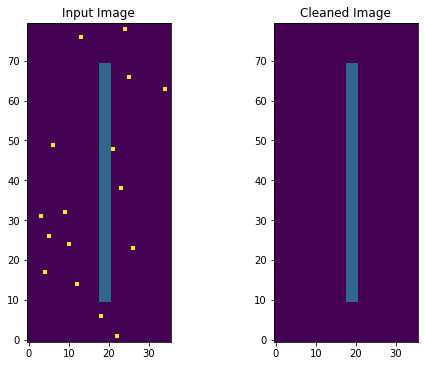

In [37]:
cleaned_image_cube = DF.pp_image_cube
cleaned_image_cube_uncertainty = DF.pp_image_cube_error
filtered_image_cube = DF.optimal_filtered_image_cube
new_bad_pixel_mask = ~DF.cumulative_image_cube_mask.astype(bool)
optimal_filter_kernel_number = DF.index_optimal_filter_kernel[0]
valid_region_fltrd_data = DF.pp_data_cube_valid_index
valid_region_data = DF.pp_roi_image_cube_index

fig, ax = plt.subplots(1,2, figsize=(7,5))
fig.tight_layout(pad=1.0)
ax[0].imshow(TEST_IMAGE_CUBE[valid_region_data][0,...], interpolation=None, origin='lower', vmin=1, vmax=10)
ax[0].set_title('Input Image')
ax[1].imshow(cleaned_image_cube[valid_region_fltrd_data][0, ...], interpolation=None, origin='lower',
             vmin=1, vmax=10)
ax[1].set_title('Cleaned Image')
plt.show()

And also plot the input and output bad pixel masks (should be the same in this case), the selected optimal filter and the filtered (smoothed) data.

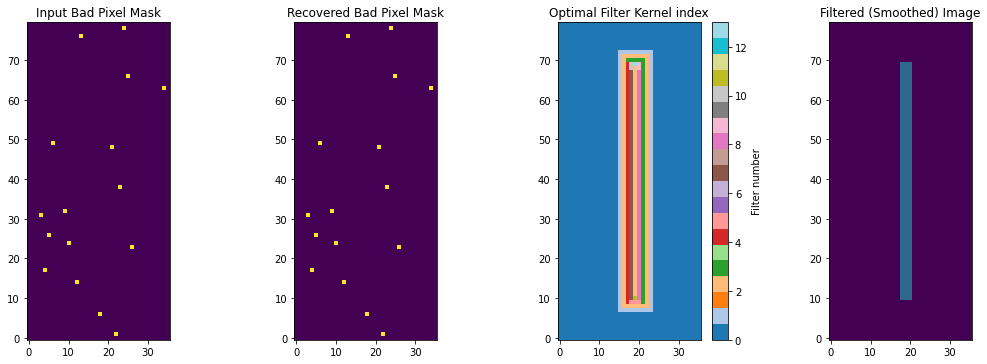

In [38]:
fig, ax = plt.subplots(1,4, figsize=(15,5))
fig.tight_layout()
ax[0].imshow(TEST_IMAGE_MASK[valid_region_data][0,...], interpolation=None, origin='lower')
ax[0].set_title('Input Bad Pixel Mask')
ax[1].imshow(new_bad_pixel_mask[valid_region_fltrd_data][0,...], interpolation=None, origin='lower')
ax[1].set_title('Recovered Bad Pixel Mask')
p = ax[2].imshow(optimal_filter_kernel_number[valid_region_fltrd_data][0, ...], interpolation=None,
                 origin='lower', cmap='tab20')
ax[2].set_title('Optimal Filter Kernel index')
fig.colorbar(p, ax=ax[2]).set_label("Filter number")
ax[3].imshow(filtered_image_cube[valid_region_fltrd_data][0,...], interpolation=None, origin='lower',
             vmin=1, vmax=10)
ax[3].set_title('Filtered (Smoothed) Image')
plt.show()